# Birds Classification Using VGG16

This notebook is for transfer learning study of VGG16 on birds classification. Please find other models in our github repo

In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

DIR_TRAIN = "train/"
DIR_VALID = "valid/"
DIR_TEST = "test/"

### Data Ingestion

In [2]:
### Exploring Dataset

classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(DIR_TRAIN + _class))
    valid_count += len(os.listdir(DIR_VALID + _class))
    test_count += len(os.listdir(DIR_TEST + _class))

print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)
    

Total Classes:  400
Total train images:  58388
Total valid images:  2000
Total test images:  2000


In [3]:
### Creating a list of all images : DIR_TRAIN/class_folder/img.jpg - FOR METHOD 2 of data loading
#   A dict for mapping class labels to index

train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}
    

Use ImageFolder class to load the train,val,test data

In [5]:
#Using Dataset Class
train_dataset = ImageFolder(root = DIR_TRAIN, transform = T.ToTensor())
valid_dataset = ImageFolder(root = DIR_VALID, transform = T.ToTensor())
test_dataset = ImageFolder(root = DIR_TEST, transform = T.ToTensor())

#Data Loader  -  using Sampler (YT Video)
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

#Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler = train_random_sampler,
    num_workers = 4,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    sampler = valid_random_sampler,
    num_workers = 4,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler,
    num_workers = 4,
)

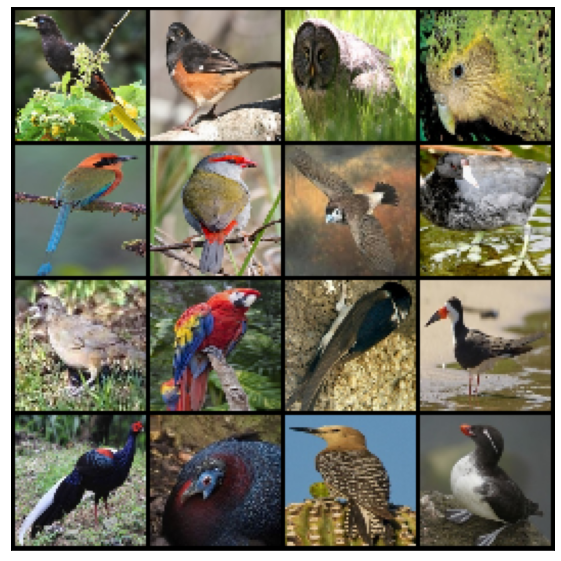

In [6]:
# Preview some of the image samples
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

### Define the CNN Baseline Model

In [9]:
# # import torch.nn as nn
# # import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(2704, 2048)
#         self.fc2 = nn.Linear(2048, 1024)
#         self.fc3 = nn.Linear(1024, 400)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# model = Net()

### Define the VGG16 networks

The following cell will download and import VGG16 net. Moreover, we modified the last few layers and add two fully connected layers and the final softmax layer

In [7]:
## Define model
model = models.vgg16(pretrained = True)

## Modifying last few layers and no of classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.2),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.2),
    nn.Linear(2048, 400))



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Define the model optimizer, loss function and lr rate for training

In [8]:
### Get device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 10


In [9]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

Next we train the model using 10 epoches

In [10]:
### Training Code

for epoch in range(epochs):
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
#         if _iter % 500 == 0:
#             print("> Iteration {} < ".format(_iter))
#             print("Iter Loss = {}".format(round(loss_value, 4)))
#             print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in valid_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
torch.save(model,'vgg.pt')

** Epoch 0 ** - Epoch Time 285
Train Loss = 5.3839
Train Accuracy = 1.8664383561643836 % 

Val Loss = 4.1578
Val Accuracy = 7.8 % 

** Epoch 1 ** - Epoch Time 287
Train Loss = 3.418
Train Accuracy = 19.15068493150685 % 

Val Loss = 2.3114
Val Accuracy = 38.0 % 

** Epoch 2 ** - Epoch Time 287
Train Loss = 2.0107
Train Accuracy = 47.428082191780824 % 

Val Loss = 1.3867
Val Accuracy = 62.45 % 

** Epoch 3 ** - Epoch Time 287
Train Loss = 1.2082
Train Accuracy = 66.64383561643835 % 

Val Loss = 0.9981
Val Accuracy = 72.85 % 

** Epoch 4 ** - Epoch Time 287
Train Loss = 0.8066
Train Accuracy = 76.79623287671232 % 

Val Loss = 0.8725
Val Accuracy = 76.65 % 

** Epoch 5 ** - Epoch Time 287
Train Loss = 0.5766
Train Accuracy = 83.2431506849315 % 

Val Loss = 0.9407
Val Accuracy = 76.75 % 

** Epoch 6 ** - Epoch Time 287
Train Loss = 0.4454
Train Accuracy = 86.66267123287672 % 

Val Loss = 0.8729
Val Accuracy = 79.3 % 

** Epoch 7 ** - Epoch Time 287
Train Loss = 0.3592
Train Accuracy = 89.21

Text(0.5, 1.0, 'Training and Validation Accuracy')

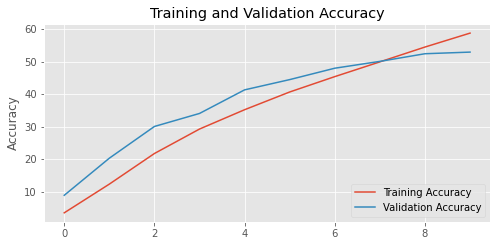

In [14]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(train_epoch_loss, label='Training Loss')
# plt.plot(val_epoch_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.ylabel('Cross Entropy')
# plt.xlabel('epoch')
# plt.show()

In [67]:
import matplotlib.pyplot as plt

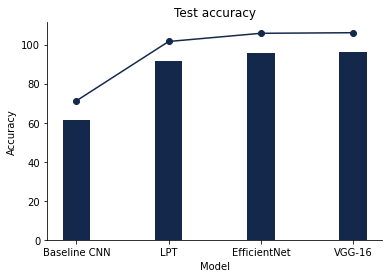

In [102]:
# plot the bar charts comparason of four models
acc=[61.2,91.6,95.8,96.1]
acc1=[i+10 for i in acc]
x=['Baseline CNN','LPT','EfficientNet','VGG-16']
fig,ax=plt.subplots()
ax.bar(x[0],acc[0],0.3,color='#14284b')
ax.bar(x[1],acc[1],0.3,color='#14284b')
ax.bar(x[2],acc[2],0.3,color='#14284b')
ax.bar(x[3],acc[3],0.3,color='#14284b')
ax.plot(x,acc1,color='#14284b',marker='o')
plt.title('Test accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Result Analysis

We then want to show the classification situation per each class. Thus we calculate the confusion matrix and find out classes with the worest classification performance: accuracy lower than 75%

In [103]:
# prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}
# confusion=np.zeros([len(classes),len(classes)],dtype=int)
# # again no gradients needed
# with torch.no_grad():
#     for data in train_data_loader:
#         images, labels = data
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             confusion[label][prediction]+=1
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1
confusion=confusion/np.sum(confusion,1)
acc_dict={}
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    if accuracy<=75:
        acc_dict[classname]=accuracy
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: ALBERTS TOWHEE is 65.2 %
Accuracy for class: COMMON FIRECREST is 65.5 %
Accuracy for class: BLACK SKIMMER is 67.5 %
Accuracy for class: TAILORBIRD is 70.9 %
Accuracy for class: WHITE CHEEKED TURACO is 70.6 %
Accuracy for class: PURPLE FINCH is 71.1 %
Accuracy for class: STRIPED OWL is 66.4 %
Accuracy for class: NORTHERN GOSHAWK is 71.7 %
Accuracy for class: CINNAMON ATTILA is 75.0 %
Accuracy for class: HAMMERKOP is 74.1 %


In [104]:
acc_dict={k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1],reverse=True)}

In [105]:
# show the confusion matrix of those classes
import pandas as pd
new_confusion=[]
new_index=[]
for classname,acc in acc_dict.items():
    new_confusion.append(100*confusion[classes.index(classname)])
    new_index.append(classname)
confusion_df=pd.DataFrame(data=new_confusion, index=new_index, columns=classes)[new_index]
confusion_df

,CINNAMON ATTILA,HAMMERKOP,NORTHERN GOSHAWK,PURPLE FINCH,TAILORBIRD,WHITE CHEEKED TURACO,BLACK SKIMMER,STRIPED OWL,COMMON FIRECREST,ALBERTS TOWHEE
CINNAMON ATTILA,79.157642,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HAMMERKOP,0.000000,76.46331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.284052
NORTHERN GOSHAWK,0.000000,0.00000,73.677446,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PURPLE FINCH,0.000000,0.00000,0.000000,81.734666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TAILORBIRD,0.000000,0.00000,0.000000,0.000000,71.285109,0.000000,0.000000,0.000000,11.453688,0.000000
WHITE CHEEKED TURACO,0.000000,0.00000,0.000000,0.000000,0.000000,71.035859,0.000000,0.000000,0.000000,0.000000
BLACK SKIMMER,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,78.691588,0.000000,0.000000,0.000000
STRIPED OWL,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,60.374371,0.000000,0.000000
COMMON FIRECREST,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.448972,0.000000
ALBERTS TOWHEE,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.412744


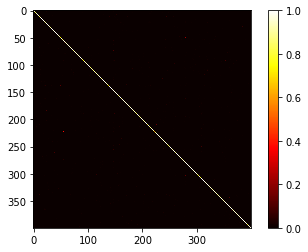

In [96]:
plt.imshow(confusion, cmap='hot', interpolation='nearest')
plt.colorbar()